## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [16]:
# Importing libraries
import os
# import boto3
# import sagemaker

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve
import xgboost as xgb
import lightgbm as lgb

from utils import read_s3_files, preprocess, predict_clusters

%matplotlib inline

In [ ]:
# sagemaker session, role
session = sagemaker.Session()
s3_client = boto3.client('s3')

In [3]:
train, test = read_s3_files(['mailout_train.csv', 'mailout_test.csv'], s3_client)
print("Train shape:", train.shape)
print("Test shape:", test.shape)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Train shape: (42962, 367)
Test shape: (42833, 366)


In [4]:
train_y = train['RESPONSE'].copy()
train_x = preprocess(train.drop('RESPONSE', axis=1))
test = preprocess(test)

----------------PART-1(Identifying missing data and data-types)----------------
Downcasting dataframe...
Memory usage before downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 120.0+ MB
None
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: category(3), datetime64[ns](1), float32(267), int16(1), int32(1), int8(91), object(2)
memory usage: 48.8+ MB
None
Identifying and replacing values representing unknown or missing data...
Replaced X with nan in following column(s):['CAMEO_DEUG_2015']
Replaced XX with nan in following column(s):['CAMEO_INTL_2015']
Replaced -1 with nan in following column(s):['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUE

In [5]:
train_x.shape

(42962, 388)

In [8]:
train_cluster = predict_clusters(train_x)
test_cluster = predict_clusters(test)

Performing Dimensionality Reduction using PCA...
Shape before PCA: (42962, 387)
Shape before PCA: (42962, 180)
Finding clusters in data...
Performing Dimensionality Reduction using PCA...
Shape before PCA: (42833, 387)
Shape before PCA: (42833, 180)
Finding clusters in data...


In [9]:
train_cluster

,0,1,2,3,4,5,6,7,8,9,...,172,173,174,175,176,177,178,179,CLUSTER,LNR
0,-7.182226,0.187454,4.609773,5.837287,-0.496500,1.013342,-4.267402,1.315556,0.390262,-0.196290,...,0.402967,0.237453,-0.810422,-0.075919,-0.054217,-0.340420,-0.680172,1.132971,3,1763.0
1,7.725657,1.041986,-3.314461,-2.836252,-2.156061,0.516340,-3.764678,1.419750,2.031265,2.047351,...,1.221896,1.241672,0.141727,-0.292178,-0.541942,-0.778153,-0.182689,-0.370895,4,1771.0
2,1.106763,-0.302178,-2.878360,4.657115,5.467867,2.277680,3.233390,2.110274,-0.053255,-1.088111,...,0.734011,-0.626888,1.371622,0.586329,-0.803731,0.198041,0.020245,-1.409442,1,1776.0
3,-0.249254,-8.177169,11.141335,2.645266,0.534873,-2.097282,2.449938,-3.461524,1.025434,-1.240244,...,-0.268486,-0.335606,0.966945,1.043623,1.746834,0.308505,2.001338,0.206794,2,1460.0
4,-1.833353,-2.427218,6.122892,3.509244,5.905100,1.822975,0.423698,3.453430,-1.055653,1.250149,...,-1.039643,0.516221,0.360774,-1.056338,-0.681541,-0.742959,-0.065323,0.262950,2,1783.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,8.215550,-0.376386,6.827886,1.202471,-2.094871,1.628754,1.061350,1.421027,-0.473854,-2.721176,...,-1.809185,-0.941040,1.078960,-0.124614,0.677304,0.073045,0.715979,0.059666,4,66338.0
42958,6.438153,2.738240,-6.053588,-0.373863,4.829053,2.066686,0.044657,2.150053,0.252102,-2.837602,...,0.266430,-1.280734,1.468274,0.673154,0.003213,0.480690,-0.445532,-1.098566,4,67629.0
42959,7.486320,-3.193941,-2.265814,0.232257,-0.030057,2.947499,3.148342,0.314993,2.465614,1.588148,...,1.004895,0.129926,0.445571,-1.466482,2.360812,0.972449,0.499622,0.298071,2,68273.0
42960,3.751761,8.577937,1.755504,1.563673,-5.459938,-3.677296,1.949818,-3.803554,-0.779987,3.560894,...,-1.335688,0.268301,-0.012517,-0.467964,-0.430864,0.695971,-0.127211,0.262410,4,68581.0


In [12]:
train_cluster['RESPONSE'] = train_y

In [14]:
test_cluster.shape

(42833, 182)

In [2]:
data_dir = 'Data/arvato'

train_cluster = pd.read_pickle(os.path.join(data_dir, 'train_mailout.pkl'))
test_cluster = pd.read_pickle(os.path.join(data_dir, 'test_mailout.pkl'))

In [60]:
# train = pd.read_csv('Data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test = pd.read_csv('Data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
train['CLUSTER'] = train_cluster['CLUSTER']
test['CLUSTER'] = test_cluster['CLUSTER']

In [63]:
# labels = train['RESPONSE'].copy()
# train = train.drop(['RESPONSE'], axis=1)
lnr = test['LNR'].copy()
# test = test.drop('LNR', axis=1)

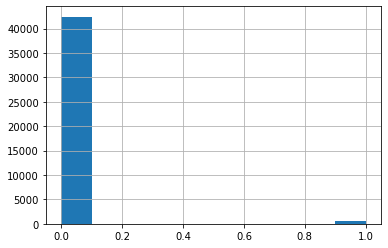

In [9]:
labels.hist()

In [7]:
pct = 100 * labels.sum() / len(labels)
print("Percentage of people who actually responded to mailout:", pct)

Percentage of people who actually responded to mailout: 1.2383036171500397


In [8]:
train_clean = preprocess(train)

----------------PART-1(Identifying missing data and data-types)----------------
Downcasting dataframe...
Memory usage before downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to CLUSTER
dtypes: float64(267), int32(1), int64(93), object(6)
memory usage: 120.1+ MB
None
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to CLUSTER
dtypes: category(3), datetime64[ns](1), float32(267), int16(1), int32(1), int8(92), object(2)
memory usage: 48.9+ MB
None
Identifying and replacing values representing unknown or missing data...
Replaced X with nan in following column(s):['CAMEO_DEUG_2015']
Replaced XX with nan in following column(s):['CAMEO_INTL_2015']
Replaced -1 with nan in following column(s):['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINI

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Downcasting data...
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 389 entries, AKT_DAT_KL to LNR
dtypes: float32(388), int32(1)
memory usage: 63.8 MB
None


In [9]:
def create_base_models():
    '''
    Creates base models.
    
    Args:
        None
    
    Returns:
        baseModels (list) - list containing base models.
    '''
    basedModels = []
    basedModels.append(('LR', LogisticRegression(solver='liblinear', random_state=SEED)))
    basedModels.append(('RF', RandomForestClassifier(n_estimators=100, random_state=SEED)))
    basedModels.append(('XGB', xgb.XGBClassifier(random_state=SEED)))
    basedModels.append(('GB', GradientBoostingClassifier(random_state=SEED)))
    basedModels.append(('MLP', MLPClassifier(random_state=SEED)))
    
    return basedModels

In [37]:
train = preprocess(train)

----------------PART-1(Identifying missing data and data-types)----------------
Downcasting dataframe...
Memory usage before downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to CLUSTER
dtypes: float64(267), int32(1), int64(93), object(6)
memory usage: 120.1+ MB
None
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to CLUSTER
dtypes: category(3), datetime64[ns](1), float32(267), int16(1), int32(1), int8(92), object(2)
memory usage: 48.9+ MB
None
Identifying and replacing values representing unknown or missing data...
Replaced X with nan in following column(s):['CAMEO_DEUG_2015']
Replaced XX with nan in following column(s):['CAMEO_INTL_2015']
Replaced -1 with nan in following column(s):['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINI

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Downcasting data...
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 389 entries, AKT_DAT_KL to LNR
dtypes: float32(388), int32(1)
memory usage: 63.8 MB
None


In [23]:
def evaluate(features, response, model):
    '''
    Evaluates models using X-Fold cross-validation. 
    Learning curve can also be plotted (optional).
    
    Args:
        features (dataframe) - dataset to be used for training.
        response (dataframe) - target variable
        models (list) - list of models to evaluated.
        curve (bool) - whether or not to plot learning curve.
        
    Returns:
        names (list) - list of models tested.
        results (list) - list of results for each model.
    '''
    cv_results = cross_val_score(model, features, response, cv=skf, scoring='roc_auc', n_jobs=-1)
    msg = "{} ({})".format(cv_results.mean(), cv_results.std())        
        
    return cv_results

In [11]:
def create_score_df(names, results):
    '''
    Creates a dataframe containing model names and corresponding score.
    
    Args:
        names (list) - list of model names.
        results (list) - list of scores.
    '''
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [38]:
train.drop('LNR', axis=1, inplace=True)

In [39]:
skf = StratifiedKFold(5)
skf.get_n_splits(train, labels)

5

We can notice that Gradient Boosting has highest score.

In [55]:
clf = lgb.LGBMClassifier(
    application='binary', boosting_type='gbdt', class_weight=None,
    colsample_bytree=1.0, importance_type='split',
    learning_rate=0.1, max_bin=100, max_depth=3,
    metric='auc', min_child_samples=0, min_child_weight=0.001,
    min_data_in_leaf=20, min_split_gain=0.0, n_estimators=20,
    n_jobs=-1, num_leaves=225, objective=None, random_state=None,
    reg_alpha=1e-09,
    scale_pos_weight=60, silent=True, subsample=1.0,
    subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [53]:
results = evaluate(train, labels, clf)

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [56]:
results.mean()

0.7611421103594112

In [48]:
results.mean()

0.7617895000480631

In [57]:
clf.fit(train, labels)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_bin=100, max_depth=3, metric='auc', min_child_samples=0,
        min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
        n_estimators=20, n_jobs=-1, num_leaves=225, objective=None,
        random_state=None, reg_alpha=1e-09, reg_lambda=0.0,
        scale_pos_weight=60, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [64]:
test = preprocess(test)

----------------PART-1(Identifying missing data and data-types)----------------
Downcasting dataframe...
Memory usage before downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 367 entries, LNR to CLUSTER
dtypes: float64(267), int32(1), int64(93), object(6)
memory usage: 119.8+ MB
None
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 367 entries, LNR to CLUSTER
dtypes: category(3), datetime64[ns](1), float32(267), int16(1), int32(1), int8(92), object(2)
memory usage: 48.7+ MB
None
Identifying and replacing values representing unknown or missing data...
Replaced X with nan in following column(s):['CAMEO_DEUG_2015']
Replaced XX with nan in following column(s):['CAMEO_INTL_2015']
Replaced -1 with nan in following column(s):['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINI

C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Downcasting data...
Memory usage after downcasting:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 389 entries, AKT_DAT_KL to LNR
dtypes: float32(388), int32(1)
memory usage: 63.6 MB
None


In [65]:
pred = clf.predict(test.drop('LNR', axis=1))

(array([31696.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11137.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

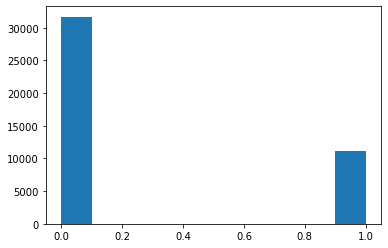

In [68]:
plt.hist(pred)

(array([31778.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11184.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

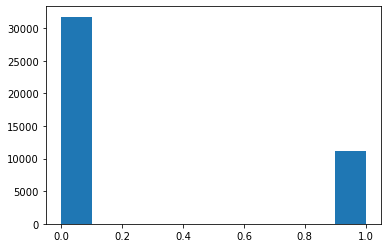

In [69]:
predt = clf.predict(train)
plt.hist(predt)

#### 

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.5148387269298786

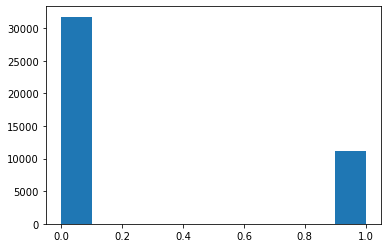

In [72]:
clf2 = lgb.LGBMClassifier(application='binary', 
                                boosting_type='gbdt', 
                                class_weight=None,
                                colsample_bytree=1.0, 
                                importance_type='split',
                                learning_rate=0.0882410095694084, 
                                max_bin=826, 
                                max_depth=2,
                                metric='auc', 
                                min_child_samples=0, 
                                min_child_weight=0.001,
                                min_data_in_leaf=32, 
                                min_split_gain=0.0, 
                                n_estimators=24,
                                n_jobs=-1, 
                                num_leaves=94, 
                                objective=None, 
                                random_state=None,
                                reg_alpha=1.0, 
                                reg_lambda=1e-09,
                                scale_pos_weight=90.0, 
                                silent=True, 
                                subsample=1.0,
                                subsample_for_bin=200000, 
                                subsample_freq=0, 
                                verbose=0)
clf.fit(train, labels)
predictions_train2 = clf.predict(train)
plt.hist(predictions_train2)
roc_auc_score(predictions_train2, labels)

In [79]:
from skopt import BayesSearchCV
# 100 - 500 to get any resonable result
# Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194)
#                           , ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), 
#                           ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0),
#                           ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])
ITERATIONS = 300
bayes_cv_tuner_lgbm = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 0.1, 'uniform'),
        'num_leaves': (2, 180),      
        'max_depth': (2, 8),
        'colsample_bytree':(0.5, 1.0, 'uniform'),
        "min_data_in_leaf":(20, 100),
        'min_child_samples': (0, 40),
        'max_bin': (100, 600),
        'reg_lambda': (1e-9, 1.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (10,90, 'uniform'),
        'n_estimators': (10, 200),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=5
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 5
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_lgbm.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_lgbm.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_lgbm.best_score_, 4),
        bayes_cv_tuner_lgbm.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_lgbm.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [77]:
%%time
result_lgbm = bayes_cv_tuner_lgbm.fit(train, labels, callback=status_print)

<IPython.core.display.Javascript object>

Model #1
Best ROC-AUC: 0.684
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #2
Best ROC-AUC: 0.684
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #3
Best ROC-AUC: 0.684
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #4
Best ROC-AUC: 0.684
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #5
Best ROC-AUC: 0.684
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #6
Best ROC-AUC: 0.7536
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #7
Best ROC-AUC: 0.7536
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #8
Best ROC-AUC: 0.7536
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #9
Best ROC-AUC: 0.7552
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #10
Best ROC-AUC: 0.7552
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #11
Best ROC-AUC: 0.76
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 225), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 1)])



<IPython.core.display.Javascript object>

Model #12
Best ROC-AUC: 0.76
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 225), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 1)])



<IPython.core.display.Javascript object>

Model #13
Best ROC-AUC: 0.7605
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #14
Best ROC-AUC: 0.7605
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #15
Best ROC-AUC: 0.7606
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 171), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #16
Best ROC-AUC: 0.7606
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 171), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #17
Best ROC-AUC: 0.7606
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 171), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #18
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #19
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #20
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #21
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #22
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #23
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #24
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #25
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #26
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #27
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #28
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #29
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #30
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #31
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #32
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #33
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #34
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #35
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #36
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #37
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #38
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #39
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #40
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #41
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #42
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #43
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #44
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #45
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #46
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #47
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #48
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #49
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #50
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #51
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #52
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #53
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #54
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #55
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #56
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #57
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #58
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #59
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #60
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #61
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #62
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #63
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #64
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #65
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #66
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #67
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #68
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #69
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #70
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #71
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #72
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #73
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #74
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #75
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #76
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #77
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #78
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #79
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #80
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #81
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #82
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #83
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #84
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #85
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #86
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #87
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #88
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #89
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #90
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #91
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #92
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #93
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #94
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #95
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #96
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #97
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #98
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #99
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #100
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #101
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #102
Best ROC-AUC: 0.7624
Best params: OrderedDict([('colsample_bytree', 0.9019708630001773), ('learning_rate', 0.13537250560801317), ('max_bin', 913), ('max_depth', 2), ('min_child_samples', 49), ('min_data_in_leaf', 100), ('n_estimators', 207), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 33)])



<IPython.core.display.Javascript object>

Model #103
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #104
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #105
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #106
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #107
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #108
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #109
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #110
Best ROC-AUC: 0.7626
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.11177404317045364), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 103), ('reg_alpha', 0.00025070342961867073), ('reg_lambda', 1e-09), ('scale_pos_weight', 27)])



<IPython.core.display.Javascript object>

Model #111
Best ROC-AUC: 0.7637
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.10226352142300527), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 160), ('reg_alpha', 0.00025490482779691486), ('reg_lambda', 1.0), ('scale_pos_weight', 36)])



<IPython.core.display.Javascript object>

Model #112
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #113
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #114
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #115
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #116
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #117
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #118
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #119
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #120
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #121
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #122
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #123
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #124
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #125
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #126
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #127
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #128
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #129
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #130
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #131
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #132
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #133
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #134
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #135
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #136
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #137
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #138
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #139
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #140
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #141
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #142
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #143
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #144
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #145
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #146
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #147
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #148
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #149
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #150
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #151
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #152
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #153
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #154
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #155
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #156
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #157
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #158
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #159
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #160
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #161
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #162
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #163
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #164
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #165
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #166
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #167
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #168
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #169
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #170
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #171
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #172
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #173
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #174
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #175
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #176
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #177
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #178
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #179
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #180
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #181
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #182
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #183
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #184
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #185
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #186
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #187
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #188
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #189
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #190
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #191
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #192
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #193
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #194
Best ROC-AUC: 0.7646
Best params: OrderedDict([('colsample_bytree', 0.9684163811365366), ('learning_rate', 0.08322887926922597), ('max_bin', 520), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 193), ('reg_alpha', 2.4022832521641505e-09), ('reg_lambda', 0.0001233498339860202), ('scale_pos_weight', 50)])



<IPython.core.display.Javascript object>

Model #195
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #196
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #197
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #198
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #199
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #200
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #201
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #202
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #203
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #204
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #205
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #206
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #207
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #208
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #209
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #210
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #211
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #212
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #213
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #214
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #215
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #216
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #217
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #218
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #219
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #220
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #221
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #222
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #223
Best ROC-AUC: 0.7666
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09856508228583047), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 172), ('reg_alpha', 0.0026000372858870917), ('reg_lambda', 1.0), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #224
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #225
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #226
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #227
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #228
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #229
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #230
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #231
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #232
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #233
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #234
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #235
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #236
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #237
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #238
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #239
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #240
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #241
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #242
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #243
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #244
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #245
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #246
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #247
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #248
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #249
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #250
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #251
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #252
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #253
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #254
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #255
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #256
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #257
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #258
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #259
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #260
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #261
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #262
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #263
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #264
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #265
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #266
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #267
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #268
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #269
Best ROC-AUC: 0.7674
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.14236425047083945), ('max_bin', 377), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 41), ('n_estimators', 20), ('num_leaves', 127), ('reg_alpha', 2.8545609694754344e-05), ('reg_lambda', 1.0), ('scale_pos_weight', 67)])



<IPython.core.display.Javascript object>

Model #270
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #271
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #272
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #273
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #274
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #275
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #276
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #277
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #278
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #279
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #280
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #281
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #282
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\Arijit Aakriti\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<IPython.core.display.Javascript object>

Model #283
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #284
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #285
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #286
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #287
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #288
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #289
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #290
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #291
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #292
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #293
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #294
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #295
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #296
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #297
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #298
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #299
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #300
Best ROC-AUC: 0.7677
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.09611180875518194), ('max_bin', 493), ('max_depth', 2), ('min_child_samples', 47), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 116), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 70)])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Wall time: 3h 9min 45s


In [85]:
result_lgbm.besbest_estimator_

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.09611180875518194, max_bin=493, max_depth=2,
        metric='auc', min_child_samples=47, min_child_weight=0.001,
        min_data_in_leaf=20, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=116, objective=None, random_state=None,
        reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=70, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=0)

In [86]:
lgb_clf= lgb.LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
                            colsample_bytree=1.0, importance_type='split',
                            learning_rate=0.09611180875518194, max_bin=493, max_depth=2,
                            metric='auc', min_child_samples=47, min_child_weight=0.001,
                            min_data_in_leaf=20, min_split_gain=0.0, n_estimators=20,
                            n_jobs=-1, num_leaves=116, objective=None, random_state=None,
                            reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=70, silent=True,
                            subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
                            verbose=0)

In [89]:
lgb_clf.fit(train, labels)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.09611180875518194, max_bin=493, max_depth=2,
        metric='auc', min_child_samples=47, min_child_weight=0.001,
        min_data_in_leaf=20, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=116, objective=None, random_state=None,
        reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=70, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=0)

In [105]:
feat_imp = pd.DataFrame(lgb_clf.feature_importances_, columns=['Feature_Importance'])
feat_imp['Features'] = train.columns

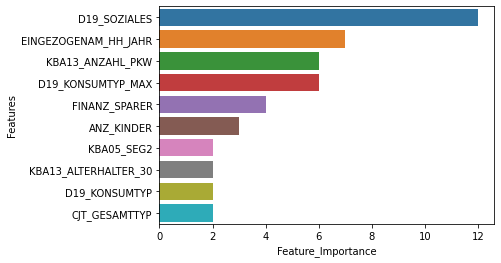

In [112]:
feat_imp = feat_imp.sort_values('Feature_Importance', ascending=False)

sns.barplot('Feature_Importance', 'Features', data=feat_imp.head(10))

In [91]:
predictions = lgb_clf.predict(train)

(array([31205.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11757.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

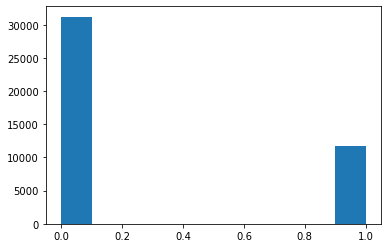

In [95]:
plt.hist(predictions)

In [96]:
# from sklearn.metrics import roc_auc_score
roc_auc_score(predictions, labels)

0.5141349345558242

In [121]:
from xgboost.sklearn import XGBRegressor 

xgb = XGBRegressor(base_score=0.5, )

In [127]:
ITERATIONS = 300
bayes_cv_tuner_lgbm_reg = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 0.3, 'uniform'),
        'num_leaves': (2, 225),      
        'max_depth': (2, 10),
        'colsample_bytree':(0.5, 1.0, 'uniform'),
        "min_data_in_leaf":(20, 100),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'reg_lambda': (1e-9, 1.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1,90, 'uniform'),
        'n_estimators': (20, 400),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=5
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 5
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_lgbm_reg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_lgbm_reg.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_lgbm_reg.best_score_, 4),
        bayes_cv_tuner_lgbm_reg.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_lgbm_reg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [128]:
%%time
result_lgbm_reg = bayes_cv_tuner_lgbm_reg.fit(train, labels, callback=status_print)

<IPython.core.display.Javascript object>

Model #1
Best ROC-AUC: 0.6878
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #2
Best ROC-AUC: 0.6878
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #3
Best ROC-AUC: 0.6878
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #4
Best ROC-AUC: 0.6878
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #5
Best ROC-AUC: 0.6878
Best params: OrderedDict([('colsample_bytree', 0.6791222670340838), ('learning_rate', 0.056036090296697996), ('max_bin', 666), ('max_depth', 6), ('min_child_samples', 12), ('min_data_in_leaf', 28), ('n_estimators', 267), ('num_leaves', 160), ('reg_alpha', 0.0006113634119921826), ('reg_lambda', 3.820294811001064e-05), ('scale_pos_weight', 6)])



<IPython.core.display.Javascript object>

Model #6
Best ROC-AUC: 0.7552
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #7
Best ROC-AUC: 0.7552
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #8
Best ROC-AUC: 0.7552
Best params: OrderedDict([('colsample_bytree', 0.922570592908447), ('learning_rate', 0.011831024125053633), ('max_bin', 583), ('max_depth', 3), ('min_child_samples', 46), ('min_data_in_leaf', 56), ('n_estimators', 120), ('num_leaves', 225), ('reg_alpha', 0.009082030275713816), ('reg_lambda', 2.9498999351256537e-05), ('scale_pos_weight', 63)])



<IPython.core.display.Javascript object>

Model #9
Best ROC-AUC: 0.7571
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #10
Best ROC-AUC: 0.7571
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #11
Best ROC-AUC: 0.7571
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #12
Best ROC-AUC: 0.7571
Best params: OrderedDict([('colsample_bytree', 0.9525566569247962), ('learning_rate', 0.07356976787822347), ('max_bin', 122), ('max_depth', 2), ('min_child_samples', 13), ('min_data_in_leaf', 89), ('n_estimators', 45), ('num_leaves', 65), ('reg_alpha', 1.038546400498543e-08), ('reg_lambda', 1.9215417604095465e-08), ('scale_pos_weight', 20)])



<IPython.core.display.Javascript object>

Model #13
Best ROC-AUC: 0.7578
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 650), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 310), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #14
Best ROC-AUC: 0.7578
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 650), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 310), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #15
Best ROC-AUC: 0.7587
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #16
Best ROC-AUC: 0.7587
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #17
Best ROC-AUC: 0.7587
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 50), ('min_data_in_leaf', 20), ('n_estimators', 20), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #18
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #19
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #20
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #21
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #22
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #23
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #24
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #25
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #26
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #27
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #28
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #29
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #30
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #31
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #32
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #33
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #34
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #35
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #36
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #37
Best ROC-AUC: 0.7601
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 161), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #38
Best ROC-AUC: 0.7612
Best params: OrderedDict([('colsample_bytree', 0.8938349449129972), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 3), ('min_child_samples', 0), ('min_data_in_leaf', 31), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 0.010385650059070307), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #39
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #40
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #41
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #42
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #43
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #44
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #45
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #46
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #47
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #48
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #49
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #50
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #51
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #52
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #53
Best ROC-AUC: 0.7618
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 10), ('min_child_samples', 0), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #54
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #55
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #56
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #57
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #58
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #59
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #60
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #61
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #62
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #63
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #64
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #65
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #66
Best ROC-AUC: 0.7621
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 499), ('max_depth', 3), ('min_child_samples', 50), ('min_data_in_leaf', 100), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1.0), ('reg_lambda', 1e-09), ('scale_pos_weight', 90)])



<IPython.core.display.Javascript object>

Model #67
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #68
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #69
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #70
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #71
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #72
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #73
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #74
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #75
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #76
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #77
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #78
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #79
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #80
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #81
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #82
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #83
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #84
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #85
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #86
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #87
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #88
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #89
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #90
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #91
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #92
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #93
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #94
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #95
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #96
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #97
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #98
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #99
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #100
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #101
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #102
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #103
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #104
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #105
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #106
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #107
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #108
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #109
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #110
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #111
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #112
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #113
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #114
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #115
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #116
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #117
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #118
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #119
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #120
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #121
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #122
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #123
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #124
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #125
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #126
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #127
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #128
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #129
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #130
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #131
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #132
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #133
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #134
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #135
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #136
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #137
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #138
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #139
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #140
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #141
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #142
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #143
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #144
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #145
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #146
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #147
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #148
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #149
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #150
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #151
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #152
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #153
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #154
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #155
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #156
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #157
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #158
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #159
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #160
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #161
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #162
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #163
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #164
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #165
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #166
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #167
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #168
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #169
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #170
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #171
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #172
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #173
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #174
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #175
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #176
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #177
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #178
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #179
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #180
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #181
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #182
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #183
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #184
Best ROC-AUC: 0.7636
Best params: OrderedDict([('colsample_bytree', 0.6799685811200057), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 8), ('min_child_samples', 10), ('min_data_in_leaf', 20), ('n_estimators', 400), ('num_leaves', 2), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 70)])



<IPython.core.display.Javascript object>

Model #185
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #186
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #187
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #188
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #189
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #190
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #191
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #192
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #193
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #194
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #195
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #196
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #197
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #198
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #199
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #200
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #201
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #202
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #203
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #204
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #205
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #206
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #207
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #208
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #209
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #210
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #211
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #212
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #213
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #214
Best ROC-AUC: 0.764
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 141), ('num_leaves', 87), ('reg_alpha', 4.6477525069919926e-06), ('reg_lambda', 0.014510163449633668), ('scale_pos_weight', 7)])



<IPython.core.display.Javascript object>

Model #215
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #216
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #217
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #218
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #219
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #220
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #221
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #222
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #223
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #224
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #225
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #226
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #227
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #228
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #229
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #230
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #231
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #232
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #233
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #234
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #235
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #236
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #237
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #238
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #239
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #240
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #241
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #242
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #243
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #244
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #245
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #246
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #247
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #248
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #249
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #250
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #251
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #252
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #253
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #254
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #255
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #256
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #257
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #258
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #259
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #260
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #261
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #262
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #263
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #264
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #265
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #266
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #267
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #268
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #269
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #270
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #271
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #272
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #273
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #274
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #275
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #276
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #277
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #278
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #279
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #280
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #281
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #282
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #283
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #284
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #285
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #286
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #287
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #288
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #289
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #290
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #291
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #292
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #293
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #294
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #295
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #296
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #297
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #298
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #299
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])



<IPython.core.display.Javascript object>

Model #300
Best ROC-AUC: 0.7643
Best params: OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.01), ('max_bin', 100), ('max_depth', 2), ('min_child_samples', 0), ('min_data_in_leaf', 20), ('n_estimators', 162), ('num_leaves', 225), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 16)])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Wall time: 3h 29min 19s


In [140]:
lgbm_reg = lgb.LGBMRegressor(boosting_type='gbdt',
                          colsample_bytree=0.5,
                          learning_rate=0.01,
                          max_bin=100,
                          max_depth=2,
#                           min_child_samples=0,
#                           min_data_in_leaf=20,
                          min_child_weight=0.001,
                          min_split_gain=0.0,
                          n_estimators=162,
                          n_jobs=-1,
                          num_leaves=225,
                          objective=None,
                          random_state=None,
                          reg_alpha=1e-09,
                          reg_lambda=1,
                          scale_pos_weight=16,
                          silent=True,
                          subsample=1.0,
                          subsample_for_bin=200000, 
                          subsample_freq=0)

In [141]:
lgbm_reg.fit(train, labels)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=0 will be ignored. Current value: min_data_in_leaf=20


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
       importance_type='split', learning_rate=0.01, max_bin=100,
       max_depth=2, min_child_samples=0, min_child_weight=0.001,
       min_data_in_leaf=20, min_split_gain=0.0, n_estimators=162,
       n_jobs=-1, num_leaves=225, objective=None, random_state=None,
       reg_alpha=1e-09, reg_lambda=1, scale_pos_weight=16, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

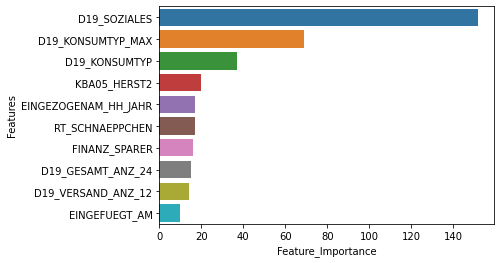

In [149]:
feat_imp = pd.DataFrame(lgbm_reg.feature_importances_, columns=['Feature_Importance'])
feat_imp['Features'] = train.columns
feat_imp = feat_imp.sort_values('Feature_Importance', ascending=False)

sns.barplot('Feature_Importance', 'Features', data=feat_imp.head(10))

(array([10918.,  7195.,  4137.,  2061.,  7797.,   667.,  1459.,  5459.,
         2969.,   300.]),
 array([0.00340575, 0.00593513, 0.00846451, 0.01099389, 0.01352328,
        0.01605266, 0.01858204, 0.02111142, 0.02364081, 0.02617019,
        0.02869957]),
 <a list of 10 Patch objects>)

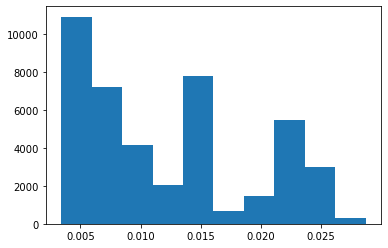

In [142]:
plt.hist(lgbm_reg.predict(train))

In [161]:
lgbm_reg = lgb.LGBMRegressor(boosting_type='gbdt',
                          colsample_bytree=0.5,
                          learning_rate=0.01,
                          max_bin=100,
                          max_depth=2,
                          min_child_weight=0.001,
                          min_split_gain=0.0,
                          n_estimators=162,
                          n_jobs=-1,
                          num_leaves=225,
                          objective='binary',
                          random_state=None,
                          reg_alpha=1e-09,
                          reg_lambda=1,
                          scale_pos_weight=16,
                          silent=True,
                          subsample=1.0,
                          subsample_for_bin=200000, 
                          subsample_freq=0)

In [162]:
lgbm_reg.fit(train, labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
       importance_type='split', learning_rate=0.01, max_bin=100,
       max_depth=2, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=162, n_jobs=-1, num_leaves=225,
       objective='binary', random_state=None, reg_alpha=1e-09,
       reg_lambda=1, scale_pos_weight=16, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

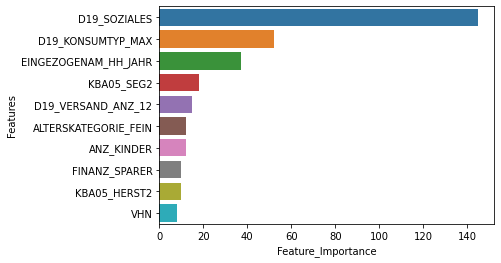

In [163]:
feat_imp = pd.DataFrame(lgbm_reg.feature_importances_, columns=['Feature_Importance'])
feat_imp['Features'] = train.columns
feat_imp = feat_imp.sort_values('Feature_Importance', ascending=False)

sns.barplot('Feature_Importance', 'Features', data=feat_imp.head(10))

(array([16461.,  7312.,   673.,  7453.,   769.,  1475.,  3621.,  4754.,
          418.,    26.]),
 array([0.02117932, 0.05607718, 0.09097504, 0.1258729 , 0.16077076,
        0.19566862, 0.23056648, 0.26546434, 0.30036219, 0.33526005,
        0.37015791]),
 <a list of 10 Patch objects>)

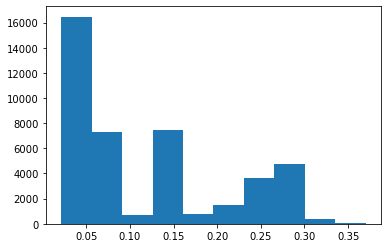

In [164]:
plt.hist(lgbm_reg.predict(train))

In [ ]:
ITERATIONS = 150
bayes_cv_tuner_xg = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
    ),
    search_spaces = {
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (1, 10),
        'min_child_weight': (1, 10),
        'gamma': (0.0, 1.0, 'uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1,90)
        
        # uncomment to test more hyperparameters
        #'max_delta_step': (0, 10),
        #'colsample_bylevel': (0.01, 1.0, 'uniform'),
        #'reg_lambda': (1e-9, 100, 'log-uniform'),
        #'scale_pos_weight': (1, 90)
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state= SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = np.random.RandomState(50)
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format },
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

#### Submission 1

In [115]:
submission = pd.DataFrame(test['LNR'].copy())
test.drop('LNR', axis=1, inplace=True)

predictions = lgb_clf.predict(test)
submission['RESPONSE'] = predictions

In [119]:
submission.index = submission['LNR']
submission.drop('LNR', axis=1, inplace=True)

,RESPONSE
LNR,
1754,1
1770,1
1465,0
1470,0
1478,0


In [120]:
submission.to_csv('submission.csv')

#### Submission 2

In [147]:
submission2 = pd.DataFrame(submission.index)
predictions = lgbm_reg.predict(test)
submission2['RESPONSE'] = predictions

submission2.to_csv('submission2.csv')

In [146]:
submission2.index = submission2['LNR']
submission2.drop('LNR', axis=1, inplace=True)

In [166]:
submission3 = pd.DataFrame(submission.index)
predictions = lgbm_reg.predict(test)
submission3['RESPONSE'] = predictions
submission3.index = submission3['LNR']
submission3.drop('LNR', axis=1, inplace=True)
submission3.to_csv('submission3.csv')

<img src='utils/Submission-Udacity+Arvato Identify Customer Segments Kaggle.png'>